## Data exploration and HR calculation <br> on MIT BIH Normal Sinus Rhythm Database and MAX86150-collected data <br> using wfdb-python and py-ecg-detectors packages
**Written by: Stamatios Aleiferis**

In [97]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import scipy as sp

import wfdb
import wfdb.processing

In [98]:
BASE_DATA_PATH = '../physionet.org/files'
DATABASE = 'nsrdb'
VERSION = '1.0.0'

In [99]:
ALL_RECORDS = np.loadtxt(os.path.join(os.getcwd(),BASE_DATA_PATH,DATABASE,VERSION,'RECORDS')).astype(np.str) #List of record names(numbers) as an array of strings
RECORD_NUMBER = '16265'

### Read file from local storage or remote database

In [100]:
FPATH = os.path.join(os.getcwd(),BASE_DATA_PATH,DATABASE,VERSION,RECORD_NUMBER) #PATH TO local FILE
sampfrom=0
sampto = None
annot_ext = 'atr'
'''
Annotations files can be
.atr  -> reference rhythm annotations
.qrs  -> unaudited beat annotations
.qrsc -> corrected beat annotations
'''

# Read signal and annotation file
record = wfdb.rdrecord(FPATH,sampfrom=sampfrom, sampto=sampto,) 
ann = wfdb.rdann(FPATH, annot_ext,return_label_elements=['symbol','description'],sampfrom=sampfrom, sampto=sampto,)

# Adjust annotation index to account for starting offset #PROBABLY NOT NEEDED, NEED TO DOUBLE CHECK
#ann.__dict__['sample'] = ann.__dict__['sample'] - sampfrom

In [101]:
# Can also directly download from web
#record2 = wfdb.rdrecord(RECORD_NUMBER, pb_dir=DATABASE)
#ann2 = wfdb.rdann(RECORD_NUMBER,'atr', pb_dir=DATABASE)

#### Record dictionary

**<li>Number of channels corresponding to leads <br><li> Sampling Frequency <br><li>Signal data <br><li>Conversion physical to digital units**

In [102]:
record.__dict__

{'record_name': '16265',
 'n_sig': 2,
 'fs': 128,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 11730944,
 'base_time': datetime.time(8, 4),
 'base_date': None,
 'comments': ['32 M'],
 'sig_name': ['ECG1', 'ECG2'],
 'p_signal': array([[-0.165, -0.325],
        [-0.155, -0.325],
        [-0.195, -0.305],
        ...,
        [-0.05 , -0.095],
        [-0.05 , -0.085],
        [-0.05 , -0.085]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['16265.dat', '16265.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'init_value': [-33, -65],
 'checksum': [15756, -21174],
 'block_size': [0, 0]}

#### Annotation dictionary

**<li>Different types of annot files (?) <br><li> Index of annot <br><li>Beat or rhythm annotation at index <br>**

In [103]:
#ann.__dict__

### Plot signal with reference beat annotation

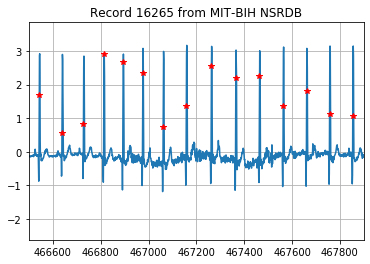

In [104]:
# Plot manually
plt.plot(record.p_signal[:,0])
plt.plot(ann.sample,record.p_signal[:,0][ann.sample],'r*')
plt.xlim((466500,467900))
plt.grid(True)
plt.title('Record '+RECORD_NUMBER+ ' from MIT-BIH'+' '+ str.upper(DATABASE));

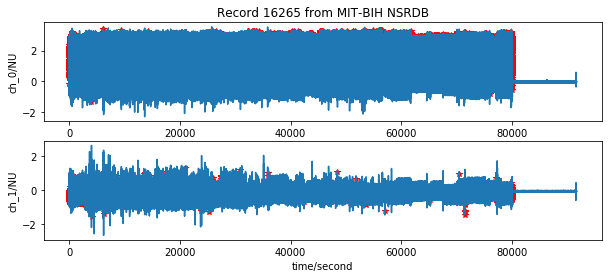

In [105]:
# Built-in function for plotting
wfdb.plot_items(signal=record.p_signal, ann_samp=[ann.sample, ann.sample],
               title='Record '+RECORD_NUMBER+ ' from MIT-BIH'+' '+ str.upper(DATABASE),
               time_units='seconds',fs=record.__dict__['fs'],figsize=(10,4))

## Calculate Heart Rate

In [106]:
sig_len = record.__dict__['p_signal'].shape[0]  # get signal length
qrs_inds = ann.__dict__['sample']               # get indices of beat annotations
fs = record.__dict__['fs']                      # get sampling frequency for current record
t = [s/fs for s in range(0,sig_len)]            # convert sample index vector to time vector (in seconds) 

In [107]:
# Calculate heart rate with WFDB built-in function
HR0 = wfdb.processing.compute_hr(sig_len, qrs_inds, fs)


Text(0.5, 1.0, 'Heart rate in BPM: Built-in function. Using database reference annotations')

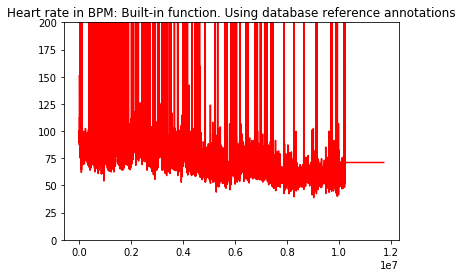

In [108]:
plt.plot(HR0,'r-')
plt.ylim((0,200))
plt.title('Heart rate in BPM: Built-in function. Using database reference annotations')

In [109]:
d = np.diff(qrs_inds)

In [110]:
# Formula for instantaneous heart rate
HRX = 60/ (d * (1.0/fs) )

Text(0.5, 1.0, 'Instantaneous heart rate in BPM: Simple Formula. Using database reference annotations')

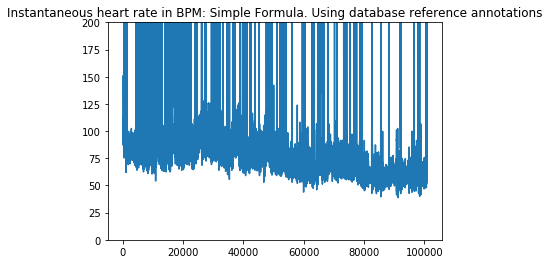

In [111]:
plt.plot(HRX)
plt.ylim((0,200))
plt.title('Instantaneous heart rate in BPM: Simple Formula. Using database reference annotations')
#plt.xlim((40000,40100))

# Test Different Peak Detectors on MIT BIH DB records

In [112]:
from ecgdetectors import Detectors

In [248]:
detectors = Detectors(record.__dict__['fs'])
#detectors = Detectors(200)

In [249]:
r_peaks = detectors.pan_tompkins_detector(record.__dict__['p_signal'])

In [250]:
#t_peaks = np.array(r_peaks)/fs #time vector

Text(0.5, 1.0, 'Peaks found with Pan-Tompkins')

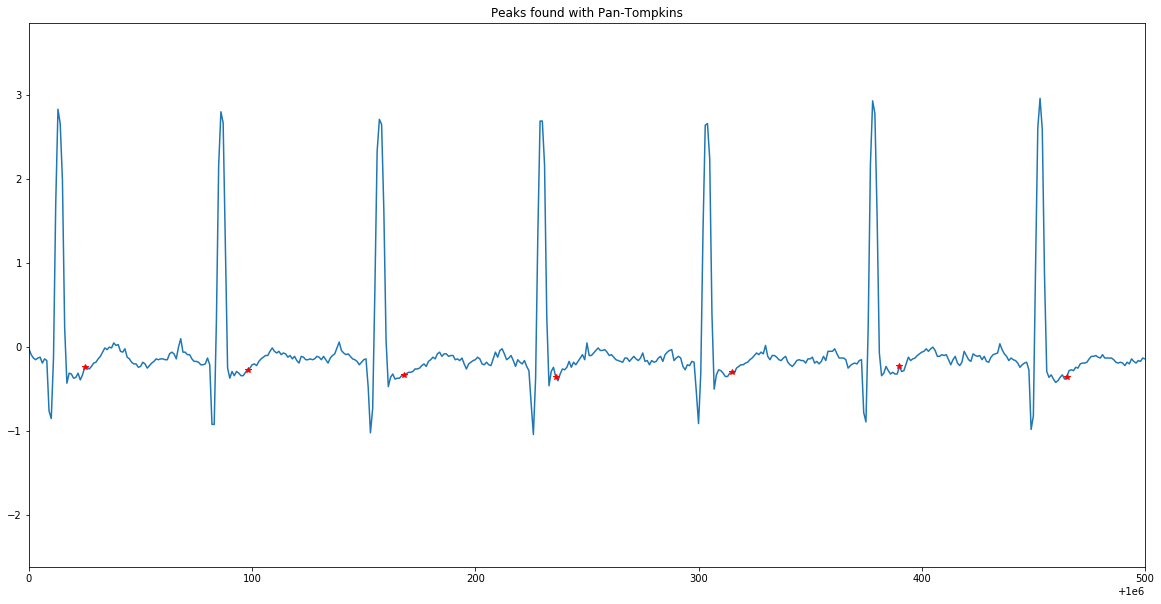

In [251]:
plt.figure(figsize=(20,10))
plt.plot(record.__dict__['p_signal'][:,0])
plt.plot(r_peaks,record.__dict__['p_signal'][:,0][r_peaks],'r*')
plt.xlim((1000000,1000500))
#plt.ylim((-1,2))
plt.title('Peaks found with Pan-Tompkins')

In [254]:
rr_s_interval = np.diff(r_peaks) # RR interval in number of samples

In [255]:
rr_interval = rr_s_interval *(1/fs) # RR interval in seconds

In [256]:
HR1 = 60/rr_interval # instantaneous HR in BPM

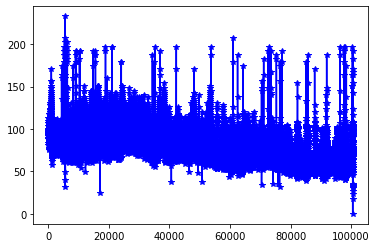

In [257]:
plt.plot(HR1,'b-*')
#plt.xlim((20130,20150))

# Engelse and Zeelenberg R-Peak Detector

In [258]:
r_peaks2 = detectors.engzee_detector(record.__dict__['p_signal'][:,0])

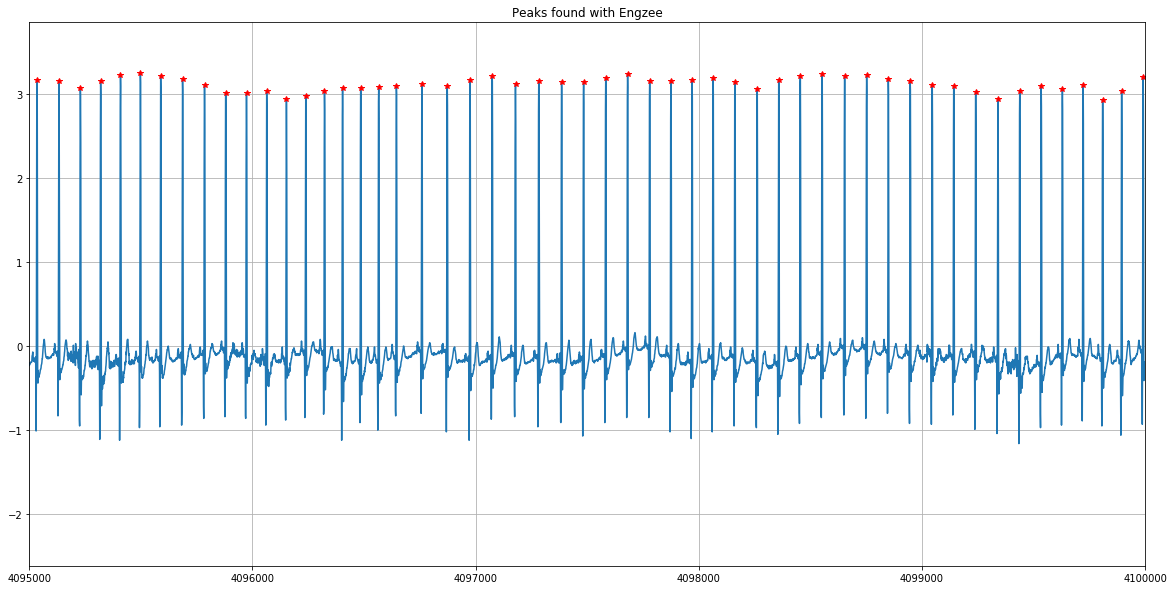

In [259]:
plt.figure(figsize=(20,10))
plt.plot(record.__dict__['p_signal'][:,0])
plt.plot(r_peaks2,record.__dict__['p_signal'][:,0][r_peaks2],'r*')
plt.xlim((4095000,4100000))
#plt.ylim((-1,2))
plt.title('Peaks found with Engzee')
plt.grid(True)

In [260]:
rr_s_interval2 = np.diff(r_peaks2)
rr_interval2 = rr_s_interval2 *(1/fs)
HR2 = 60/rr_interval2 

Text(0.5, 1.0, 'Heart rate in BPM. Engzee R-peak detector. Manual HR formula')

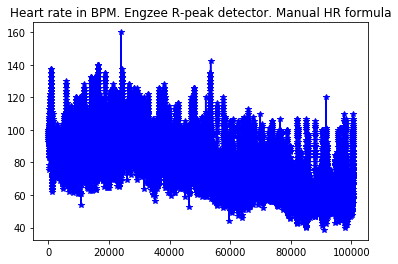

In [261]:
plt.plot(HR2,'b-*')
#plt.xlim((20000,21020))
plt.title('Heart rate in BPM. Engzee R-peak detector. Manual HR formula')

In [262]:
HR3 = wfdb.processing.compute_hr(sig_len, r_peaks2, fs)

Text(0.5, 1.0, 'Heart rate in BPM. Engzee R-peak detector. Built-in HR function')

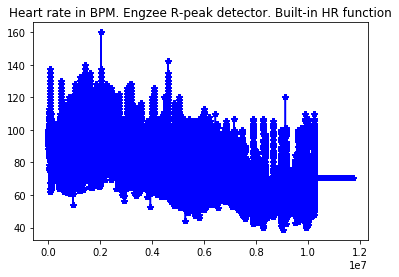

In [263]:
plt.plot(HR3,'b-*')
plt.title('Heart rate in BPM. Engzee R-peak detector. Built-in HR function')
#plt.xlim((20000,21020))

# Test with data from MAX86150

In [88]:
import pandas as pd

In [365]:
data = pd.read_csv('ECPPG_2020-01-07_01-07-14.csv')
#data = pd.read_csv('ECPPG_2020-01-11_00-41-26.csv')

In [366]:
Fs = 200 # ECG sample rate in Hz
detectorsMAX = Detectors(Fs)

In [367]:
rawECG = data.values[:,5][1:].astype(np.float)
filteredECG = data.values[:,7][1:].astype(np.float) # Max-filtered data

In [368]:
b_HPF, a_HPF = sp.signal.butter(3, [3,25], btype='bandpass', analog=False, output='ba', fs=Fs) # Butterworth Bandpass 3-25 Hz


In [369]:
filtECG = sp.signal.filtfilt(b_HPF,a_HPF,filteredECG)

Text(0.5, 1.0, 'Filtered ECG (3rd Order Butterworth Bandpass)')

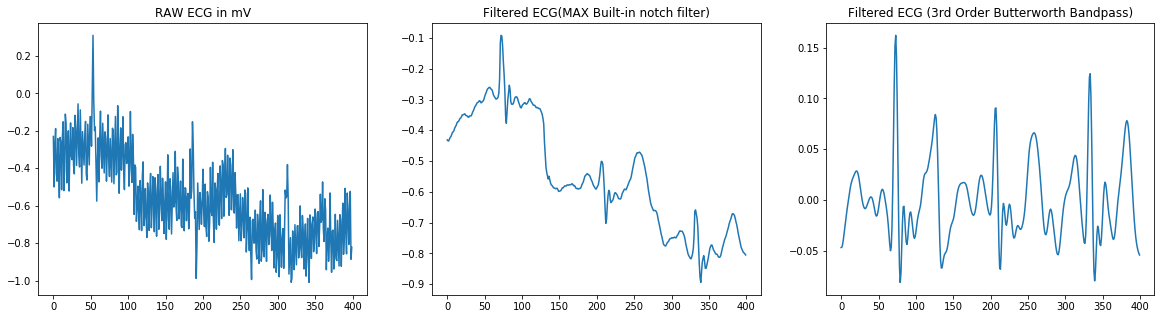

In [370]:
# Plot
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
# Raw ECG
ax1.plot(rawECG[600:1000])
ax1.set_title('RAW ECG in mV')
# Filtered ECG with MAX digital filter
ax2.plot(filteredECG[600:1000])
ax2.set_title('Filtered ECG(MAX Built-in notch filter)')
# Band-pass filtered ECG 
ax3.plot(filtECG[600:1000])
plt.title('Filtered ECG (3rd Order Butterworth Bandpass)')

In [192]:
r_peaks_MAX = detectorsMAX.engzee_detector((filtECG[600:-1700]))

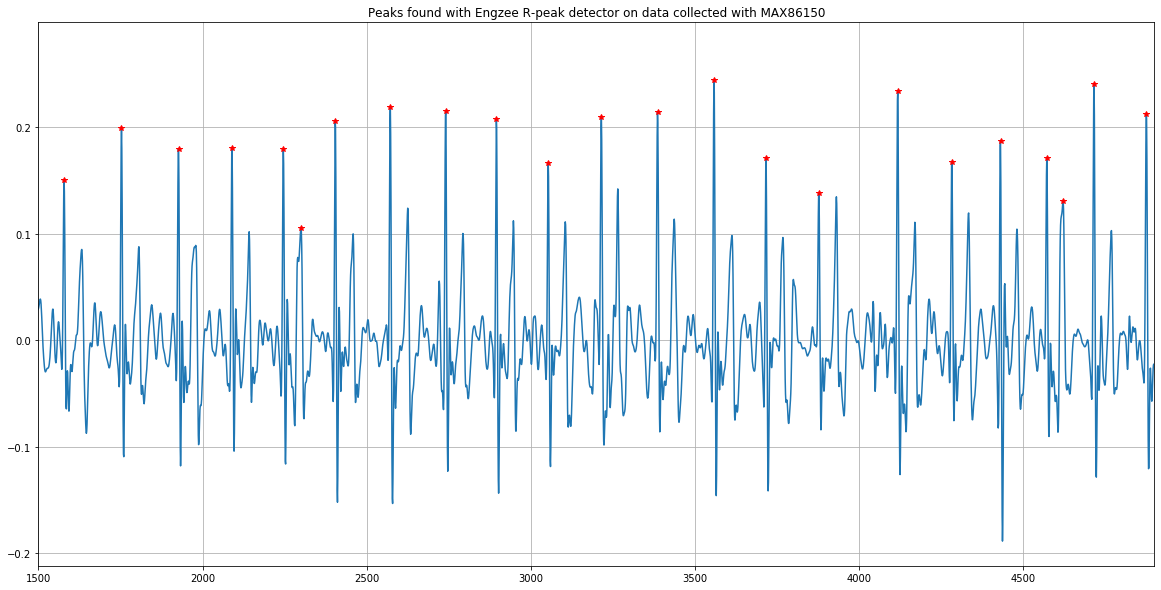

In [225]:
plt.figure(figsize=(20,10))
plt.plot(filtECG[600:-1700])
plt.plot(np.asarray(r_peaks_MAX),filtECG[600:-1700][r_peaks_MAX],'r*')
plt.xlim((1500,4900))
#plt.ylim((-1,2))
plt.title('Peaks found with Engzee R-peak detector on data collected with MAX86150')
plt.grid(True)

In [215]:
rr_s_interval_MAX = np.diff(r_peaks_MAX)
rr_interval_MAX = rr_s_interval_MAX *(1/Fs)
HR_MAX = 60/rr_interval_MAX
HR_MAX_bultin = wfdb.processing.compute_hr(sig_len, r_peaks_MAX, Fs)

Text(0.5, 1.0, 'Instantaneous HR in BPM, Engzee R-peak detector, data collected with MAX86150, manual calculation')

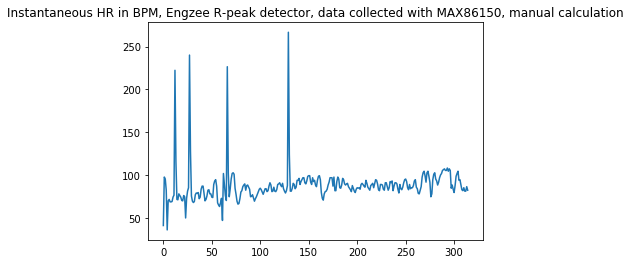

In [223]:
plt.plot(HR_MAX)
plt.title('Instantaneous HR in BPM, Engzee R-peak detector, data collected with MAX86150, manual calculation')

Text(0.5, 1.0, 'Instantaneous HR in BPM, Engzee R-peak detector, data collected with MAX86150, built-in HR function')

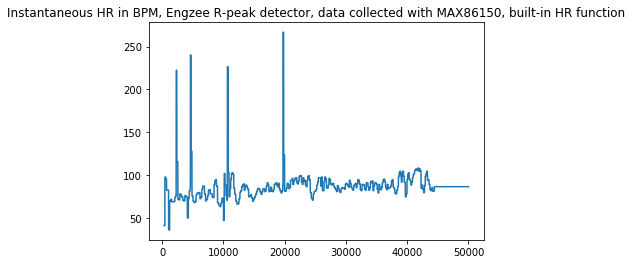

In [224]:
plt.plot(HR_MAX_bultin[0:50000])
plt.title('Instantaneous HR in BPM, Engzee R-peak detector, data collected with MAX86150, built-in HR function')

In [1]:
from py_ecg_detectors.tester_MITDB import MITDB_test 

In [2]:
tester = MITDB_test()

In [92]:
result = tester.classifer_test_all(tolerance=5)


two_average
MITDB progress: 0%
MITDB progress: 2%
MITDB progress: 4%
MITDB progress: 6%
MITDB progress: 8%
MITDB progress: 10%
MITDB progress: 12%
MITDB progress: 14%
MITDB progress: 16%
MITDB progress: 18%
MITDB progress: 20%
MITDB progress: 22%
MITDB progress: 25%
MITDB progress: 27%
MITDB progress: 29%
MITDB progress: 31%
MITDB progress: 33%
MITDB progress: 35%
MITDB progress: 37%
MITDB progress: 39%
MITDB progress: 41%
MITDB progress: 43%
MITDB progress: 45%
MITDB progress: 47%
MITDB progress: 50%
MITDB progress: 52%
MITDB progress: 54%
MITDB progress: 56%
MITDB progress: 58%
MITDB progress: 60%
MITDB progress: 62%
MITDB progress: 64%
MITDB progress: 66%
MITDB progress: 68%
MITDB progress: 70%
MITDB progress: 72%
MITDB progress: 75%
MITDB progress: 77%
MITDB progress: 79%
MITDB progress: 81%
MITDB progress: 83%
MITDB progress: 85%
MITDB progress: 87%
MITDB progress: 89%
MITDB progress: 91%
MITDB progress: 93%
MITDB progress: 95%
MITDB progress: 97%

swt
MITDB progress: 0%
MITDB pr

In [18]:
py_ecg_detectors

<module 'py_ecg_detectors' (namespace)>

In [18]:
result['two_average TP'][:5]

213    2260
207       0
212     235
210    1768
205    2166
Name: two_average TP, dtype: int64

In [94]:
det_names = ['two_average', 'swt', 'engzee', 'christov', 'hamilton', 'pan_tompkins']
#det_names = ['two_average']
res_dict = dict()

In [95]:
for det_name in det_names:
    
    res_dict[det_name] = dict()
    
    TP = result[det_name+ ' TP']
    FP = result[det_name+ ' FP']
    FN = result[det_name+ ' FN']
    TN = result[det_name+ ' TN']
    
    TPR = np.mean( ( TP / (TP+FN) ).dropna() ) #sensitivity
    ACC = np.mean( ( (TP + TN) / (TP+TN+FN+FP) ).dropna() ) # accuracy 
    TNR = np.mean( ( TN / (TN + FP) ).dropna() ) #specificity
    PPV = np.mean( ( TP / (TP + FP) ).dropna() ) #precision
    
    res_dict[det_name]['sensitivity'] = TPR
    res_dict[det_name]['specificity'] = TPR
    res_dict[det_name]['precision'] = TNR
    res_dict[det_name]['accuracy'] = ACC
    
    
    
    

In [41]:
a = result[['two_average TP','two_average FP','two_average FN','two_average TN']]

In [96]:
pd.DataFrame(res_dict)

,two_average,swt,engzee,christov,hamilton,pan_tompkins
sensitivity,0.830543,0.826246,0.847843,0.220473,0.632512,0.522641
specificity,0.830543,0.826246,0.847843,0.220473,0.632512,0.522641
precision,0.999395,0.999478,0.999744,0.990981,0.998702,0.998317
accuracy,0.998846,0.998899,0.999247,0.988318,0.997419,0.996656


In [74]:
g = dict()

In [76]:
g['method1'] = dict()

In [77]:
g['method1']['precision'] = 0.5
g['method1']['recall'] = 0.6

In [113]:
from pandas.table.plotting import table

ModuleNotFoundError: No module named 'pandas.table'

In [93]:
result

,two_average TP,two_average FP,two_average FN,two_average TN,swt TP,swt FP,swt FN,swt TN,engzee TP,engzee FP,...,christov FN,christov TN,hamilton TP,hamilton FP,hamilton FN,hamilton TN,pan_tompkins TP,pan_tompkins FP,pan_tompkins FN,pan_tompkins TN
213,3152,97,99,646652,2919,233,332,646516,3149,81,...,0,0,2243,988,1008,645761,1007,2243,2244,644506
207,7,2176,1853,645964,2,1780,1858,646360,192,250,...,1619,639763,1,1899,1859,646241,142,1942,1718,646198
212,2733,14,15,647238,2740,2,8,647250,2746,0,...,0,0,647,2176,2101,645076,1452,1296,1296,645956
210,2459,176,191,647174,2449,174,201,647176,2446,36,...,2264,639264,1917,644,733,646706,1468,1160,1182,646190
205,2527,118,129,647226,2582,47,74,647297,2581,11,...,0,0,1893,754,763,646590,1486,1165,1170,646179
201,1901,134,62,647903,1862,13,101,648024,1888,14,...,0,0,1182,712,781,647325,1025,888,938,647149
215,3332,28,31,646609,3350,10,13,646627,3352,5,...,195,646442,2746,614,617,646023,2354,1008,1009,645629
214,2228,41,34,647697,2167,72,95,647666,2136,102,...,1883,639473,2022,233,240,647505,1186,1072,1076,646666
200,1843,771,758,646628,1845,785,756,646614,1812,186,...,0,0,1281,1316,1320,646083,1172,1430,1429,645969
228,901,1245,1152,646702,1691,422,362,647525,1718,436,...,1948,644307,1462,598,591,647349,1180,893,873,647054
